In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Bayes_FM")
os.listdir()

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import uniform
#from BFM.MCMC_MGP import Gibbs_sampling
#from BFM.MCMC_LH import Gibbs_sampling
from BFM.MCMC_CSP import Gibbs_sampling
from BFM.VI import NGVI

In [2]:
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
P = 1000
K = 5
N = 500

In [4]:
B_0 = np.random.binomial(1,1/3,(P,K)) * np.random.rand(P,K)
sigma2_0 = np.diag(uniform.rvs(loc = 0.1, scale = 0.9, size = P))
cov_0 = B_0 @ B_0.T + sigma2_0

In [5]:
X = np.random.multivariate_normal(np.zeros(P), cov_0, N)

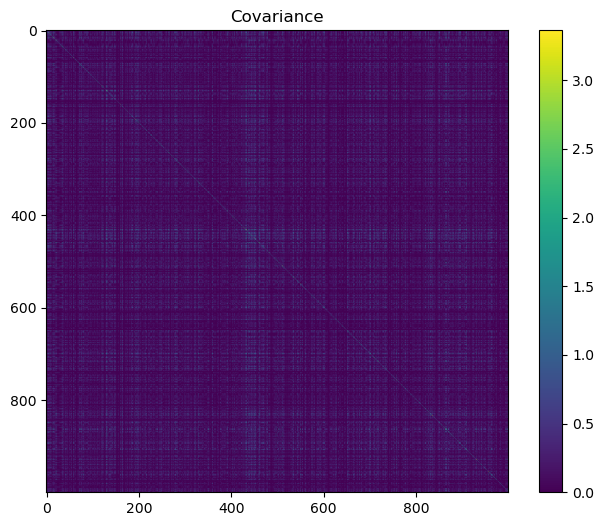

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(cov_0)
plt.colorbar()
plt.title("Covariance")
plt.show()

In [ ]:
#B_sample, sigma2_sample = Gibbs_sampling(torch.from_numpy(X).to(device1), a = 1, b = 100, c = 0.3)
B_sample, sigma2_sample = Gibbs_sampling(torch.from_numpy(X).to(device1))


In [7]:
mu, Precision, np_sigma = NGVI(torch.from_numpy(X).to(device1), a = 1, b = 100, c = 0.25, v = 1000)

100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


In [8]:
v = 1000
B = mu @ mu.T + (v / (v-2)) * torch.diag(torch.vmap(torch.trace)(torch.linalg.inv(Precision))) + torch.diag(np_sigma / (0.5 * N))

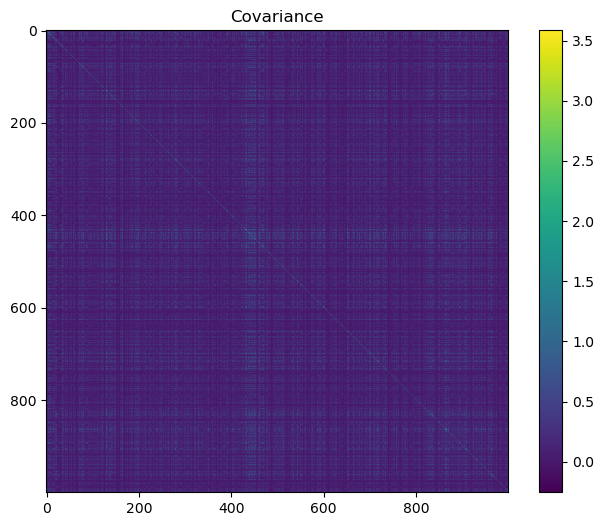

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(B.to('cpu'))
plt.colorbar()
plt.title("Covariance")
plt.show()

In [10]:
(torch.from_numpy(cov_0) - B.to('cpu')).square().sum()/P**2

tensor(0.0022, dtype=torch.float64)

In [11]:
(torch.from_numpy(cov_0) - B.to('cpu')).abs().sum()/P**2

tensor(0.0300, dtype=torch.float64)

In [ ]:
for i in range(50):
    print(mu[:,i].abs().sum())

In [ ]:
A = torch.einsum('bij,bjk->bik',B_sample, B_sample.transpose(1,2))
for i in range(10000):
    A[i] = A[i] + torch.diag(sigma2_sample[i])

In [ ]:
A_mean = A.mean(0)

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(A_mean)
plt.colorbar()
plt.title("Covariance")
plt.show()

In [ ]:
(torch.from_numpy(cov_0) - A_mean).square().sum() / P**2

In [ ]:
(torch.from_numpy(cov_0) - A_mean).abs().sum() / P**2

In [ ]:
B_mean = B_sample.mean(0)

In [ ]:
for i in range(50):
    print(B_mean[:,i].abs().sum())